<a href="https://colab.research.google.com/github/eddylim95/CZ4042_NeuralNet_project/blob/master/Assignment_2/start_project_2a.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [2]:
# For google colab use
%tensorflow_version 1.x
from google.colab import drive
drive.mount('/content/drive/')
%cd 'drive/My Drive/CZ4042_NeuralNet_project'

Go to this URL in a browser: https://accounts.google.com/o/oauth2/auth?client_id=947318989803-6bn6qk8qdgf4n4g3pfee6491hc0brc4i.apps.googleusercontent.com&redirect_uri=urn%3Aietf%3Awg%3Aoauth%3A2.0%3Aoob&scope=email%20https%3A%2F%2Fwww.googleapis.com%2Fauth%2Fdocs.test%20https%3A%2F%2Fwww.googleapis.com%2Fauth%2Fdrive%20https%3A%2F%2Fwww.googleapis.com%2Fauth%2Fdrive.photos.readonly%20https%3A%2F%2Fwww.googleapis.com%2Fauth%2Fpeopleapi.readonly&response_type=code

Enter your authorization code:
··········
Mounted at /content/drive/
/content/drive/My Drive/CZ4042_NeuralNet_project


In [0]:
# To add a new cell, type '# %%'
# To add a new markdown cell, type '# %% [markdown]'
# Change working directory from the workspace root to the ipynb file location. Turn this addition off with the DataScience.changeDirOnImportExport setting
# ms-python.python added
import os
try:
	os.chdir(os.path.join(os.getcwd(), 'Assignment_2'))
	print(os.getcwd())
except:
	pass

import math
import tensorflow as tf
import numpy as np
import matplotlib.pyplot as plt
import pickle
from tqdm import tqdm_notebook as tqdm
import sys

NUM_CLASSES = 10
IMG_SIZE = 32
NUM_CHANNELS = 3
learning_rate = 0.001
epochs = 200
batch_size = 128

seed = 10
np.random.seed(seed)
tf.set_random_seed(seed)

def load_data(file):
    with open(file, 'rb') as fo:
        try:
            samples = pickle.load(fo)
        except UnicodeDecodeError:  #python 3.x
            fo.seek(0)
            samples = pickle.load(fo, encoding='latin1')

    data, labels = samples['data'], samples['labels']

    data = np.array(data, dtype=np.float32)
    labels = np.array(labels, dtype=np.int32)

    
    labels_ = np.zeros([labels.shape[0], NUM_CLASSES])
    labels_[np.arange(labels.shape[0]), labels-1] = 1

    return data, labels_

def cnn(images, num_filter_1, num_filter_2, dropout=False):
    # NHWC format
    images = tf.reshape(images, [-1, IMG_SIZE, IMG_SIZE, NUM_CHANNELS])
    
    #Conv 1, 50 filters of window size 9x9, VALID padding, and ReLU
    with tf.variable_scope('CNN_Layer1'):
        conv1 = tf.layers.conv2d(
            images,
            filters=num_filter_1,
            kernel_size=[9,9],
            padding='VALID',
            activation=tf.nn.relu)
        pool1 = tf.layers.max_pooling2d(
            conv1,
            pool_size=2,
            strides=2,
            padding='VALID')
        if dropout:
            pool1 = tf.layers.dropout(pool1, 0.25)

    with tf.variable_scope('Char_CNN_Layer2'):
        conv2 = tf.layers.conv2d(
            pool1,
            filters=num_filter_2,
            kernel_size=[5,5],
            padding='VALID',
            activation=tf.nn.relu)
        pool2 = tf.layers.max_pooling2d(
            conv2,
            pool_size=2,
            strides=2,
            padding='VALID')
        if dropout:
            pool2 = tf.layers.dropout(pool2, 0.25)

    # pool2_ = tf.squeeze(tf.reduce_max(pool2, 1), squeeze_dims=[1])
    dim = pool2.get_shape()[1].value * pool2.get_shape()[2].value * pool2.get_shape()[3].value 
    pool2_ = tf.reshape(pool2, [-1, dim])
    
    # Fully connected layer size 300
    f3 = tf.layers.dense(pool2_, 300, activation=tf.nn.relu)
    if dropout:
        f3 = tf.layers.dropout(f3, 0.5)

    #Softmax, size 10. Note that softmax happens at softmax_entropy step
    f4 = tf.layers.dense(f3, NUM_CLASSES, activation=None)

    return conv1, pool1, conv2, pool2, f4

def plot_acc(filename: str, epochs: int, test_acc: list):
    fig, ax = plt.subplots(figsize=[12.8,9.6])
    ax.plot(range(epochs), test_acc, label=f'Test accuracy')
    ax.legend(loc='best')
    plt.savefig(filename)
    plt.show()

def plot_all_acc(filename: str, epochs: int, acc_list: list, layer_1_search: list, layer_2_search: list):
    fig, ax = plt.subplots(figsize=[12.8,9.6])
    idx = 0
    for i in layer_1_search:
        for j in layer_2_search:
            ax.plot(range(epochs), acc_list[idx], label=f'Test accuracy for layer1={i}, layer2={j}')
            idx += 1
    ax.legend(loc='best')
    plt.savefig(filename)
    plt.show()

def plot_cost(filename: str, epochs: int, train_cost: list):
    fig, ax = plt.subplots(figsize=[12.8,9.6])
    ax.plot(range(epochs), train_cost, label=f'Train cost')
    ax.legend(loc='best')
    plt.savefig(filename)
    plt.show()

def plot_optimizer_cost(filename: str, epochs: int, cost_list: list, optimizer_list: list, dropout_list: list):
    fig, ax = plt.subplots(figsize=[12.8,9.6])
    for i, optimizer in enumerate(optimizer_list):
        text = '' if dropout_list[i] else 'out'
        ax.plot(range(epochs), cost_list[i], label=f'Train cost for {optimizer} with{text} dropout')
    ax.legend(loc='best')
    plt.savefig(filename)
    plt.show()

def plot_optimizer_acc(filename: str, epochs: int, acc_list: list, optimizer_list: list, dropout_list: list):
    fig, ax = plt.subplots(figsize=[12.8,9.6])
    for i, optimizer in enumerate(optimizer_list):
        text = '' if dropout_list[i] else 'out'
        ax.plot(range(epochs), acc_list[i], label=f'Test accuracy for {optimizer} with{text} dropout')
    ax.legend(loc='best')
    plt.savefig(filename)
    plt.show()

def plot_layer(filename, layer, num_filters):
    """Note that there is an assumption that num_filters is a multiple of 10
    """
    plt.figure()
    plt.gray()
    layer_ = np.array(layer)
    for i in range(num_filters):
        plt.subplot(num_filters/10, 10, i+1)
        plt.axis('off')
        plt.imshow(layer_[0,:,:,i])
    plt.savefig(filename)

def plot_feature_maps(X, conv_1, pool_1, conv_2, pool_2, i):
    # Test pattern
    plt.figure()
    plt.gray()
    X_show = X.reshape(NUM_CHANNELS, IMG_SIZE, IMG_SIZE).transpose(1, 2, 0)
    plt.axis('off')
    plt.imshow(X_show)
    plt.savefig(f'partA_plots/q1a_test_pattern_{i}.png')

    # Conv 1
    plot_layer(f'partA_plots/q1a_conv1_{i}.png' ,conv_1, 50)

    # Pool 1
    plot_layer(f'partA_plots/q1a_pool1_{i}.png' ,pool_1, 50)

    # Conv 2
    plot_layer(f'partA_plots/q1a_conv2_{i}.png' ,conv_2, 60)

    # Pool 2
    plot_layer(f'partA_plots/q1a_pool2_{i}.png' ,pool_2, 60)


In [0]:
trainX, trainY = load_data('data_batch_1')
print(trainX.shape, trainY.shape)

testX, testY = load_data('test_batch_trim')
print(testX.shape, testY.shape)

trainX = (trainX - np.min(trainX, axis = 0))/np.max(trainX, axis = 0)

# Check GPU status
print('Gpu status: ' + str(tf.test.is_gpu_available()))


epoch 0 accuracy 0.107
epoch 10 accuracy 0.206
epoch 20 accuracy 0.2615
epoch 30 accuracy 0.2625
epoch 40 accuracy 0.2895
epoch 50 accuracy 0.297
epoch 60 accuracy 0.271
epoch 70 accuracy 0.2925
epoch 80 accuracy 0.305
epoch 90 accuracy 0.264
epoch 100 accuracy 0.3195
epoch 110 accuracy 0.307
epoch 120 accuracy 0.3375
epoch 130 accuracy 0.335
epoch 140 accuracy 0.3485
epoch 150 accuracy 0.3615
epoch 160 accuracy 0.357
epoch 170 accuracy 0.367
epoch 180 accuracy 0.372
epoch 190 accuracy 0.3255


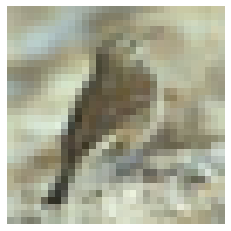

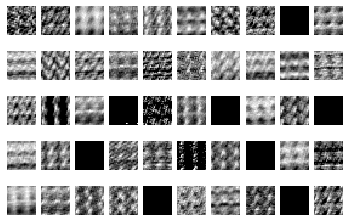

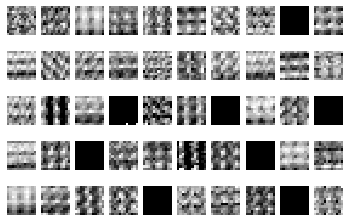

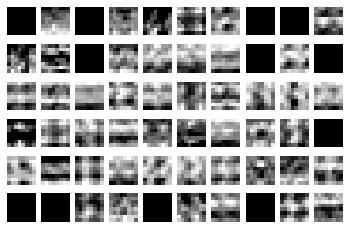

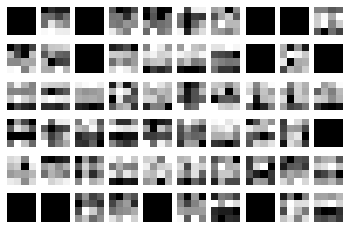

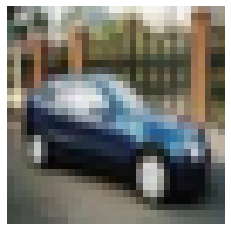

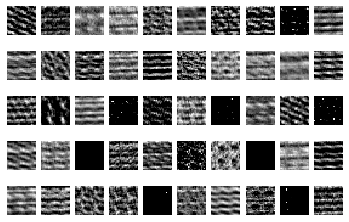

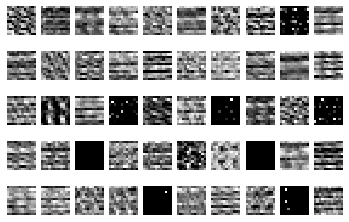

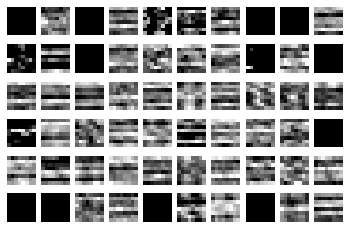

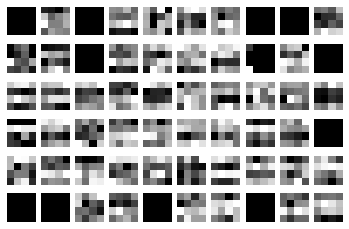

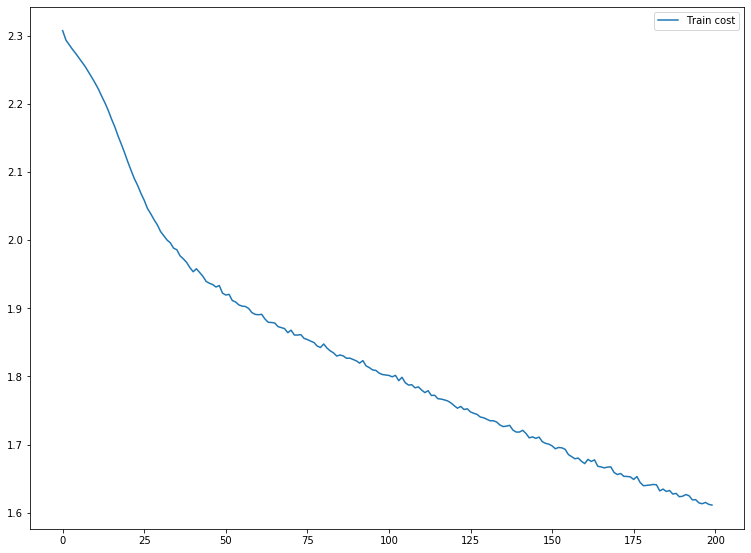

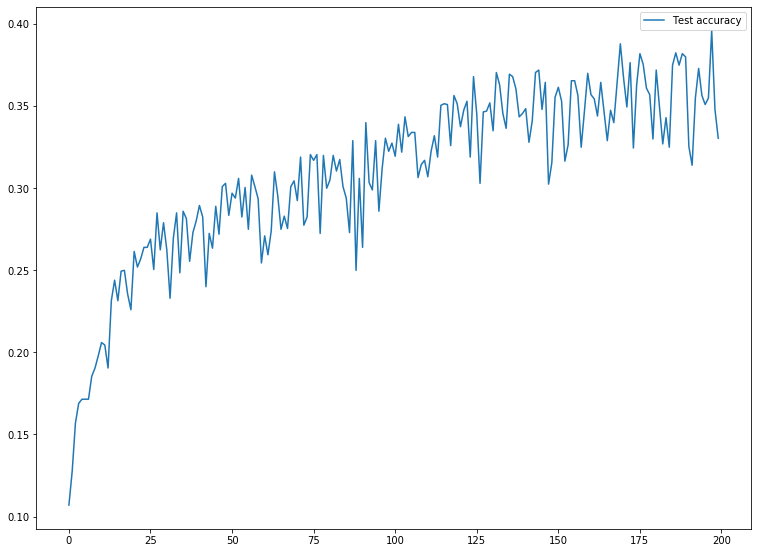

In [67]:
# Q1
# Create the model
tf.reset_default_graph()

x = tf.placeholder(tf.float32, [None, IMG_SIZE*IMG_SIZE*NUM_CHANNELS])
y_ = tf.placeholder(tf.float32, [None, NUM_CLASSES])

conv_1, pool_1, conv_2, pool_2, logits = cnn(x, 50, 60)
cross_entropy = tf.nn.softmax_cross_entropy_with_logits_v2(labels=y_, logits=logits)
loss = tf.reduce_mean(cross_entropy)
train_step = tf.train.GradientDescentOptimizer(learning_rate).minimize(loss)

correct_prediction = tf.equal(tf.argmax(logits, 1), tf.argmax(y_, 1))
correct_prediction = tf.cast(correct_prediction, tf.float32)
accuracy = tf.reduce_mean(correct_prediction)

N = len(trainX)
idx = np.arange(N)

train_cost = []
test_acc = []

with tf.Session() as sess:
    sess.run(tf.global_variables_initializer())

    for e in tqdm(range(epochs)):
        np.random.shuffle(idx)
        train_X, train_Y = trainX[idx], trainY[idx]
        train_cost_ = []
        # Handle in batches
        for start, end in zip(range(0, len(train_X), batch_size), range(batch_size, len(train_X), batch_size)):
            _, batch_cost = sess.run([train_step, loss], {x: train_X[start:end], y_: train_Y[start:end]})
            train_cost_.append(batch_cost)
        _, batch_cost = sess.run([train_step, loss], {x: train_X[end:], y_: train_Y[end:]})
        train_cost_.append(batch_cost)
        train_cost.append(np.mean(np.array(train_cost_), axis=0))
        test_acc.append(accuracy.eval(feed_dict={x: testX, y_: testY}))
        if e % 10 == 0:
            print('epoch', e, 'accuracy', test_acc[e])

    # Plot feature maps
    for i in range(2):
        ind = np.random.randint(low=0, high=10000)
        X = trainX[ind,:]
        conv_1_, pool_1_, conv_2_, pool_2_ = sess.run([conv_1, pool_1, conv_2, pool_2],
                                                    {x: X.reshape(1,IMG_SIZE*IMG_SIZE*NUM_CHANNELS)})
        plot_feature_maps(X, conv_1_, pool_1_, conv_2_, pool_2_, i)

plot_cost('partA_plots/q1a_1.png', epochs, train_cost)
plot_acc('partA_plots/q1a_2.png', epochs, test_acc)

In [31]:
# Q2
layer_1_search = [4, 8, 16, 32, 64]
layer_2_search = [4, 8, 16, 32, 64]

all_acc = []
for i in layer_1_search:
    for j in layer_2_search:
        # Create the model
        tf.reset_default_graph()

        x = tf.placeholder(tf.float32, [None, IMG_SIZE*IMG_SIZE*NUM_CHANNELS])
        y_ = tf.placeholder(tf.float32, [None, NUM_CLASSES])

        conv_1, pool_1, conv_2, pool_2, logits = cnn(x, i, j)
        cross_entropy = tf.nn.softmax_cross_entropy_with_logits_v2(labels=y_, logits=logits)
        loss = tf.reduce_mean(cross_entropy)
        train_step = tf.train.GradientDescentOptimizer(learning_rate).minimize(loss)

        correct_prediction = tf.equal(tf.argmax(logits, 1), tf.argmax(y_, 1))
        correct_prediction = tf.cast(correct_prediction, tf.float32)
        accuracy = tf.reduce_mean(correct_prediction)

        N = len(trainX)
        idx = np.arange(N)

        test_acc = []

        with tf.Session() as sess:
            sess.run(tf.global_variables_initializer())

            for e in tqdm(range(epochs)):
                np.random.shuffle(idx)
                train_X, train_Y = trainX[idx], trainY[idx]
                # Handle in batches
                for start, end in zip(range(0, len(train_X), batch_size), range(batch_size, len(train_X), batch_size)):
                    sess.run([train_step, loss], {x: train_X[start:end], y_: train_Y[start:end]})
                test_acc.append(accuracy.eval(feed_dict={x: testX, y_: testY}))
                if e % 10 == 0:
                    print('epoch', e, 'accuracy', test_acc[e])
        all_acc.append(test_acc)


epoch 0 accuracy 0.105
epoch 10 accuracy 0.106
epoch 20 accuracy 0.1095
epoch 30 accuracy 0.1105
epoch 40 accuracy 0.116
epoch 50 accuracy 0.119
epoch 60 accuracy 0.124
epoch 70 accuracy 0.1335
epoch 80 accuracy 0.1385
epoch 90 accuracy 0.14
epoch 100 accuracy 0.143
epoch 110 accuracy 0.177
epoch 120 accuracy 0.208
epoch 130 accuracy 0.218
epoch 140 accuracy 0.229
epoch 150 accuracy 0.234
epoch 160 accuracy 0.2395
epoch 170 accuracy 0.238
epoch 180 accuracy 0.238
epoch 190 accuracy 0.2475


epoch 0 accuracy 0.134
epoch 10 accuracy 0.128
epoch 20 accuracy 0.2145
epoch 30 accuracy 0.2555
epoch 40 accuracy 0.274
epoch 50 accuracy 0.2825
epoch 60 accuracy 0.293
epoch 70 accuracy 0.291
epoch 80 accuracy 0.2955
epoch 90 accuracy 0.3205
epoch 100 accuracy 0.323
epoch 110 accuracy 0.3225
epoch 120 accuracy 0.326
epoch 130 accuracy 0.346
epoch 140 accuracy 0.3245
epoch 150 accuracy 0.3305
epoch 160 accuracy 0.302
epoch 170 accuracy 0.3205
epoch 180 accuracy 0.34
epoch 190 accuracy 0.3325


epoch 0 accuracy 0.102
epoch 10 accuracy 0.162
epoch 20 accuracy 0.165
epoch 30 accuracy 0.2025
epoch 40 accuracy 0.2355
epoch 50 accuracy 0.267
epoch 60 accuracy 0.2855
epoch 70 accuracy 0.29
epoch 80 accuracy 0.2915
epoch 90 accuracy 0.3035
epoch 100 accuracy 0.319
epoch 110 accuracy 0.3155
epoch 120 accuracy 0.321
epoch 130 accuracy 0.328
epoch 140 accuracy 0.327
epoch 150 accuracy 0.3215
epoch 160 accuracy 0.341
epoch 170 accuracy 0.3465
epoch 180 accuracy 0.3465
epoch 190 accuracy 0.3505


epoch 0 accuracy 0.0985
epoch 10 accuracy 0.1845
epoch 20 accuracy 0.2335
epoch 30 accuracy 0.272
epoch 40 accuracy 0.2865
epoch 50 accuracy 0.298
epoch 60 accuracy 0.2975
epoch 70 accuracy 0.3065
epoch 80 accuracy 0.3105
epoch 90 accuracy 0.331
epoch 100 accuracy 0.333
epoch 110 accuracy 0.351
epoch 120 accuracy 0.3535
epoch 130 accuracy 0.3505
epoch 140 accuracy 0.3565
epoch 150 accuracy 0.361
epoch 160 accuracy 0.375
epoch 170 accuracy 0.3595
epoch 180 accuracy 0.374
epoch 190 accuracy 0.365


epoch 0 accuracy 0.0985
epoch 10 accuracy 0.1435
epoch 20 accuracy 0.196
epoch 30 accuracy 0.2405
epoch 40 accuracy 0.2625
epoch 50 accuracy 0.2805
epoch 60 accuracy 0.291
epoch 70 accuracy 0.313
epoch 80 accuracy 0.3085
epoch 90 accuracy 0.3195
epoch 100 accuracy 0.3245
epoch 110 accuracy 0.34
epoch 120 accuracy 0.3355
epoch 130 accuracy 0.3355
epoch 140 accuracy 0.342
epoch 150 accuracy 0.3265
epoch 160 accuracy 0.327
epoch 170 accuracy 0.3295
epoch 180 accuracy 0.3465
epoch 190 accuracy 0.339


epoch 0 accuracy 0.123
epoch 10 accuracy 0.1695
epoch 20 accuracy 0.213
epoch 30 accuracy 0.2265
epoch 40 accuracy 0.2655
epoch 50 accuracy 0.2875
epoch 60 accuracy 0.2905
epoch 70 accuracy 0.2975
epoch 80 accuracy 0.3035
epoch 90 accuracy 0.2995
epoch 100 accuracy 0.2975
epoch 110 accuracy 0.313
epoch 120 accuracy 0.3265
epoch 130 accuracy 0.3165
epoch 140 accuracy 0.32
epoch 150 accuracy 0.33
epoch 160 accuracy 0.3345
epoch 170 accuracy 0.321
epoch 180 accuracy 0.322
epoch 190 accuracy 0.3265


epoch 0 accuracy 0.1075
epoch 10 accuracy 0.168
epoch 20 accuracy 0.193
epoch 30 accuracy 0.2045
epoch 40 accuracy 0.219
epoch 50 accuracy 0.227
epoch 60 accuracy 0.264
epoch 70 accuracy 0.2765
epoch 80 accuracy 0.273
epoch 90 accuracy 0.2745
epoch 100 accuracy 0.2925
epoch 110 accuracy 0.287
epoch 120 accuracy 0.294
epoch 130 accuracy 0.279
epoch 140 accuracy 0.269
epoch 150 accuracy 0.296
epoch 160 accuracy 0.285
epoch 170 accuracy 0.32
epoch 180 accuracy 0.3015
epoch 190 accuracy 0.3245


epoch 0 accuracy 0.0825
epoch 10 accuracy 0.1935
epoch 20 accuracy 0.2625
epoch 30 accuracy 0.271
epoch 40 accuracy 0.283
epoch 50 accuracy 0.3045
epoch 60 accuracy 0.297
epoch 70 accuracy 0.31
epoch 80 accuracy 0.322
epoch 90 accuracy 0.318
epoch 100 accuracy 0.326
epoch 110 accuracy 0.3355
epoch 120 accuracy 0.344
epoch 130 accuracy 0.3485
epoch 140 accuracy 0.3545
epoch 150 accuracy 0.3555
epoch 160 accuracy 0.3505
epoch 170 accuracy 0.345
epoch 180 accuracy 0.349
epoch 190 accuracy 0.3465


epoch 0 accuracy 0.1275
epoch 10 accuracy 0.166
epoch 20 accuracy 0.2265
epoch 30 accuracy 0.2595
epoch 40 accuracy 0.2735
epoch 50 accuracy 0.291
epoch 60 accuracy 0.2875
epoch 70 accuracy 0.3025
epoch 80 accuracy 0.304
epoch 90 accuracy 0.312
epoch 100 accuracy 0.3225
epoch 110 accuracy 0.325
epoch 120 accuracy 0.339
epoch 130 accuracy 0.3405
epoch 140 accuracy 0.343
epoch 150 accuracy 0.348
epoch 160 accuracy 0.357
epoch 170 accuracy 0.358
epoch 180 accuracy 0.3735
epoch 190 accuracy 0.3555


epoch 0 accuracy 0.1
epoch 10 accuracy 0.143
epoch 20 accuracy 0.1725
epoch 30 accuracy 0.207
epoch 40 accuracy 0.2535
epoch 50 accuracy 0.268
epoch 60 accuracy 0.282
epoch 70 accuracy 0.297
epoch 80 accuracy 0.3205
epoch 90 accuracy 0.3285
epoch 100 accuracy 0.3255
epoch 110 accuracy 0.3225
epoch 120 accuracy 0.333
epoch 130 accuracy 0.3345
epoch 140 accuracy 0.3385
epoch 150 accuracy 0.35
epoch 160 accuracy 0.3555
epoch 170 accuracy 0.341
epoch 180 accuracy 0.3425
epoch 190 accuracy 0.3465


epoch 0 accuracy 0.115
epoch 10 accuracy 0.1525
epoch 20 accuracy 0.165
epoch 30 accuracy 0.178
epoch 40 accuracy 0.219
epoch 50 accuracy 0.2475
epoch 60 accuracy 0.268
epoch 70 accuracy 0.28
epoch 80 accuracy 0.276
epoch 90 accuracy 0.3065
epoch 100 accuracy 0.2935
epoch 110 accuracy 0.3095
epoch 120 accuracy 0.3015
epoch 130 accuracy 0.313
epoch 140 accuracy 0.311
epoch 150 accuracy 0.3145
epoch 160 accuracy 0.3145
epoch 170 accuracy 0.3355
epoch 180 accuracy 0.331
epoch 190 accuracy 0.288


epoch 0 accuracy 0.1035
epoch 10 accuracy 0.1285
epoch 20 accuracy 0.161
epoch 30 accuracy 0.2265
epoch 40 accuracy 0.2365
epoch 50 accuracy 0.255
epoch 60 accuracy 0.267
epoch 70 accuracy 0.3085
epoch 80 accuracy 0.3075
epoch 90 accuracy 0.307
epoch 100 accuracy 0.3315
epoch 110 accuracy 0.334
epoch 120 accuracy 0.341
epoch 130 accuracy 0.3375
epoch 140 accuracy 0.34
epoch 150 accuracy 0.342
epoch 160 accuracy 0.345
epoch 170 accuracy 0.3455
epoch 180 accuracy 0.3365
epoch 190 accuracy 0.367


epoch 0 accuracy 0.108
epoch 10 accuracy 0.143
epoch 20 accuracy 0.1855
epoch 30 accuracy 0.2225
epoch 40 accuracy 0.2495
epoch 50 accuracy 0.2735
epoch 60 accuracy 0.2895
epoch 70 accuracy 0.291
epoch 80 accuracy 0.2835
epoch 90 accuracy 0.2905
epoch 100 accuracy 0.294
epoch 110 accuracy 0.2905
epoch 120 accuracy 0.316
epoch 130 accuracy 0.3085
epoch 140 accuracy 0.3135
epoch 150 accuracy 0.321
epoch 160 accuracy 0.3255
epoch 170 accuracy 0.319
epoch 180 accuracy 0.3245
epoch 190 accuracy 0.3245


epoch 0 accuracy 0.0855
epoch 10 accuracy 0.185
epoch 20 accuracy 0.2495
epoch 30 accuracy 0.2935
epoch 40 accuracy 0.2935
epoch 50 accuracy 0.297
epoch 60 accuracy 0.3165
epoch 70 accuracy 0.329
epoch 80 accuracy 0.3365
epoch 90 accuracy 0.3465
epoch 100 accuracy 0.352
epoch 110 accuracy 0.352
epoch 120 accuracy 0.357
epoch 130 accuracy 0.368
epoch 140 accuracy 0.358
epoch 150 accuracy 0.3565
epoch 160 accuracy 0.3785
epoch 170 accuracy 0.37
epoch 180 accuracy 0.365
epoch 190 accuracy 0.365


epoch 0 accuracy 0.094
epoch 10 accuracy 0.177
epoch 20 accuracy 0.226
epoch 30 accuracy 0.267
epoch 40 accuracy 0.283
epoch 50 accuracy 0.2845
epoch 60 accuracy 0.2895
epoch 70 accuracy 0.308
epoch 80 accuracy 0.3255
epoch 90 accuracy 0.3255
epoch 100 accuracy 0.332
epoch 110 accuracy 0.3255
epoch 120 accuracy 0.3515
epoch 130 accuracy 0.346
epoch 140 accuracy 0.3595
epoch 150 accuracy 0.363
epoch 160 accuracy 0.351
epoch 170 accuracy 0.37
epoch 180 accuracy 0.3595
epoch 190 accuracy 0.3595


epoch 0 accuracy 0.1035
epoch 10 accuracy 0.136
epoch 20 accuracy 0.1605
epoch 30 accuracy 0.1655
epoch 40 accuracy 0.226
epoch 50 accuracy 0.2505
epoch 60 accuracy 0.2665
epoch 70 accuracy 0.2875
epoch 80 accuracy 0.284
epoch 90 accuracy 0.3035
epoch 100 accuracy 0.319
epoch 110 accuracy 0.3275
epoch 120 accuracy 0.3385
epoch 130 accuracy 0.3315
epoch 140 accuracy 0.337
epoch 150 accuracy 0.3525
epoch 160 accuracy 0.352
epoch 170 accuracy 0.3565
epoch 180 accuracy 0.3665
epoch 190 accuracy 0.3625


epoch 0 accuracy 0.1
epoch 10 accuracy 0.147
epoch 20 accuracy 0.182
epoch 30 accuracy 0.1685
epoch 40 accuracy 0.205
epoch 50 accuracy 0.266
epoch 60 accuracy 0.2735
epoch 70 accuracy 0.294
epoch 80 accuracy 0.2825
epoch 90 accuracy 0.3035
epoch 100 accuracy 0.3065
epoch 110 accuracy 0.324
epoch 120 accuracy 0.305
epoch 130 accuracy 0.3485
epoch 140 accuracy 0.3595
epoch 150 accuracy 0.3545
epoch 160 accuracy 0.364
epoch 170 accuracy 0.35
epoch 180 accuracy 0.3555
epoch 190 accuracy 0.3345


epoch 0 accuracy 0.098
epoch 10 accuracy 0.1575
epoch 20 accuracy 0.2015
epoch 30 accuracy 0.2195
epoch 40 accuracy 0.2655
epoch 50 accuracy 0.2795
epoch 60 accuracy 0.293
epoch 70 accuracy 0.2785
epoch 80 accuracy 0.3115
epoch 90 accuracy 0.3035
epoch 100 accuracy 0.33
epoch 110 accuracy 0.3285
epoch 120 accuracy 0.328
epoch 130 accuracy 0.3415
epoch 140 accuracy 0.336
epoch 150 accuracy 0.3395
epoch 160 accuracy 0.3475
epoch 170 accuracy 0.3315
epoch 180 accuracy 0.3335
epoch 190 accuracy 0.3345


epoch 0 accuracy 0.1125
epoch 10 accuracy 0.16
epoch 20 accuracy 0.2385
epoch 30 accuracy 0.2705
epoch 40 accuracy 0.302
epoch 50 accuracy 0.3045
epoch 60 accuracy 0.3125
epoch 70 accuracy 0.3095
epoch 80 accuracy 0.3335
epoch 90 accuracy 0.3385
epoch 100 accuracy 0.347
epoch 110 accuracy 0.3385
epoch 120 accuracy 0.3605
epoch 130 accuracy 0.352
epoch 140 accuracy 0.3335
epoch 150 accuracy 0.361
epoch 160 accuracy 0.348
epoch 170 accuracy 0.353
epoch 180 accuracy 0.3455
epoch 190 accuracy 0.3575


epoch 0 accuracy 0.11
epoch 10 accuracy 0.166
epoch 20 accuracy 0.2215
epoch 30 accuracy 0.261
epoch 40 accuracy 0.2865
epoch 50 accuracy 0.311
epoch 60 accuracy 0.312
epoch 70 accuracy 0.3215
epoch 80 accuracy 0.3185
epoch 90 accuracy 0.342
epoch 100 accuracy 0.343
epoch 110 accuracy 0.3365
epoch 120 accuracy 0.367
epoch 130 accuracy 0.3645
epoch 140 accuracy 0.354
epoch 150 accuracy 0.3715
epoch 160 accuracy 0.385
epoch 170 accuracy 0.383
epoch 180 accuracy 0.37
epoch 190 accuracy 0.3565


epoch 0 accuracy 0.098
epoch 10 accuracy 0.119
epoch 20 accuracy 0.1095
epoch 30 accuracy 0.109
epoch 40 accuracy 0.137
epoch 50 accuracy 0.1575
epoch 60 accuracy 0.164
epoch 70 accuracy 0.164
epoch 80 accuracy 0.166
epoch 90 accuracy 0.181
epoch 100 accuracy 0.2025
epoch 110 accuracy 0.2185
epoch 120 accuracy 0.2335
epoch 130 accuracy 0.249
epoch 140 accuracy 0.2555
epoch 150 accuracy 0.2605
epoch 160 accuracy 0.26
epoch 170 accuracy 0.2585
epoch 180 accuracy 0.2555
epoch 190 accuracy 0.261


epoch 0 accuracy 0.119
epoch 10 accuracy 0.1545
epoch 20 accuracy 0.226
epoch 30 accuracy 0.255
epoch 40 accuracy 0.278
epoch 50 accuracy 0.2905
epoch 60 accuracy 0.293
epoch 70 accuracy 0.316
epoch 80 accuracy 0.3285
epoch 90 accuracy 0.321
epoch 100 accuracy 0.3325
epoch 110 accuracy 0.331
epoch 120 accuracy 0.323
epoch 130 accuracy 0.3155
epoch 140 accuracy 0.3025
epoch 150 accuracy 0.327
epoch 160 accuracy 0.274
epoch 170 accuracy 0.319
epoch 180 accuracy 0.2975
epoch 190 accuracy 0.2905


epoch 0 accuracy 0.144
epoch 10 accuracy 0.195
epoch 20 accuracy 0.2465
epoch 30 accuracy 0.2765
epoch 40 accuracy 0.2955
epoch 50 accuracy 0.299
epoch 60 accuracy 0.3065
epoch 70 accuracy 0.3095
epoch 80 accuracy 0.322
epoch 90 accuracy 0.315
epoch 100 accuracy 0.317
epoch 110 accuracy 0.2875
epoch 120 accuracy 0.3135
epoch 130 accuracy 0.3045
epoch 140 accuracy 0.315
epoch 150 accuracy 0.2815
epoch 160 accuracy 0.2845
epoch 170 accuracy 0.2675
epoch 180 accuracy 0.292
epoch 190 accuracy 0.2915


epoch 0 accuracy 0.1415
epoch 10 accuracy 0.195
epoch 20 accuracy 0.2365
epoch 30 accuracy 0.2735
epoch 40 accuracy 0.2935
epoch 50 accuracy 0.296
epoch 60 accuracy 0.303
epoch 70 accuracy 0.312
epoch 80 accuracy 0.325
epoch 90 accuracy 0.329
epoch 100 accuracy 0.3395
epoch 110 accuracy 0.3555
epoch 120 accuracy 0.3425
epoch 130 accuracy 0.3445
epoch 140 accuracy 0.361
epoch 150 accuracy 0.3695
epoch 160 accuracy 0.368
epoch 170 accuracy 0.358
epoch 180 accuracy 0.366
epoch 190 accuracy 0.3725


epoch 0 accuracy 0.1005
epoch 10 accuracy 0.212
epoch 20 accuracy 0.2555
epoch 30 accuracy 0.2695
epoch 40 accuracy 0.2855
epoch 50 accuracy 0.295
epoch 60 accuracy 0.3115
epoch 70 accuracy 0.3225
epoch 80 accuracy 0.322
epoch 90 accuracy 0.328
epoch 100 accuracy 0.3475
epoch 110 accuracy 0.3375
epoch 120 accuracy 0.355
epoch 130 accuracy 0.3555
epoch 140 accuracy 0.3295
epoch 150 accuracy 0.3515
epoch 160 accuracy 0.3295
epoch 170 accuracy 0.3485
epoch 180 accuracy 0.3615
epoch 190 accuracy 0.353


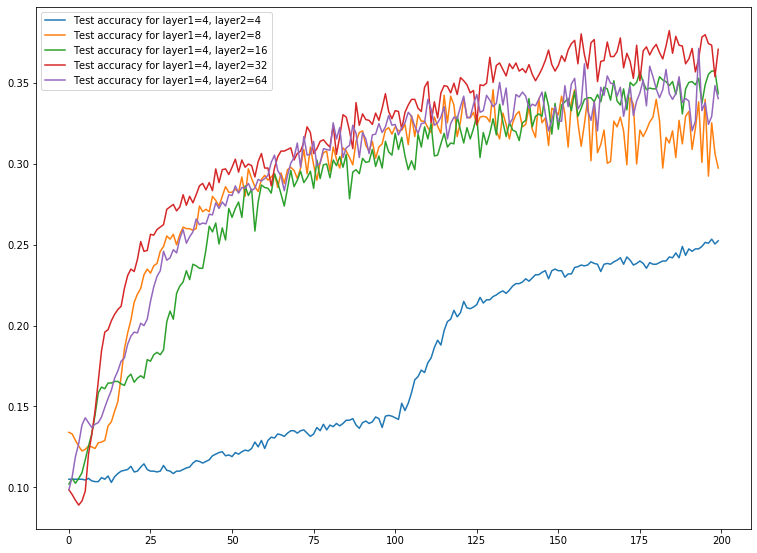

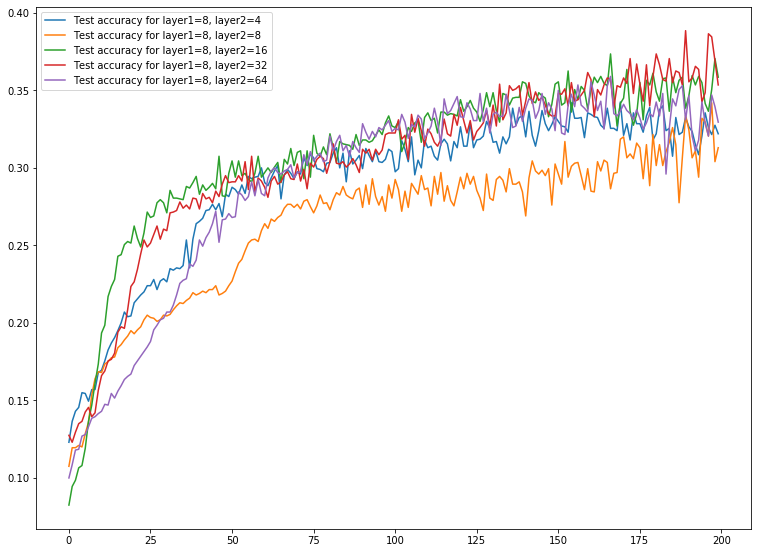

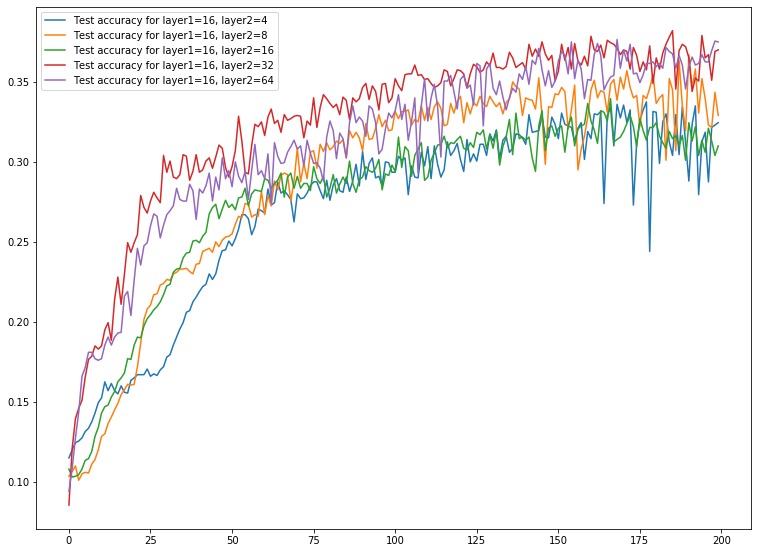

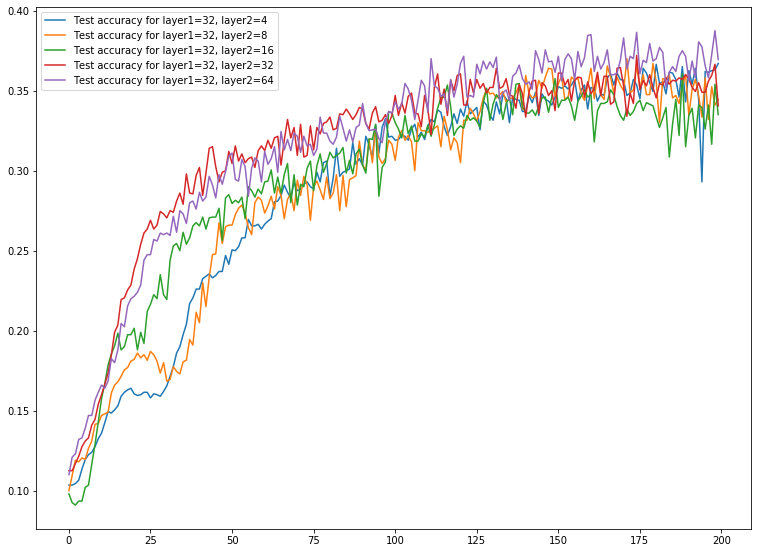

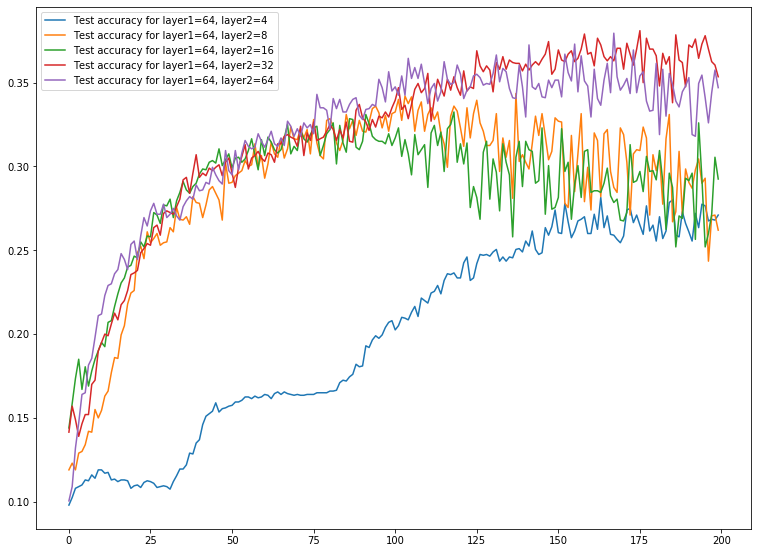

In [35]:
for i, size in enumerate(layer_1_search):
    plot_all_acc(f'partA_plots/q2_{i}.png', epochs, all_acc[i*5:i*5+5], [size], layer_2_search)

In [42]:
# Q3

comparisons = [
               {'optimizer': 'gd', 'dropout': False},
               {'optimizer': 'momentum', 'dropout': False},
               {'optimizer': 'rms', 'dropout': False},
               {'optimizer': 'adam', 'dropout': False},
               {'optimizer': 'gd', 'dropout': True}
]

all_cost = []
all_acc = []
for item in comparisons:
    tf.reset_default_graph()

    x = tf.placeholder(tf.float32, [None, IMG_SIZE*IMG_SIZE*NUM_CHANNELS])
    y_ = tf.placeholder(tf.float32, [None, NUM_CLASSES])

    conv_1, pool_1, conv_2, pool_2, logits = cnn(x, 32, 64, dropout=item['dropout'])
    cross_entropy = tf.nn.softmax_cross_entropy_with_logits_v2(labels=y_, logits=logits)
    loss = tf.reduce_mean(cross_entropy)

    if item['optimizer'] == 'gd':
        train_step = tf.train.GradientDescentOptimizer(learning_rate).minimize(loss)
    elif item['optimizer'] == 'momentum':
        train_step = tf.train.MomentumOptimizer(learning_rate, 0.1).minimize(loss)
    elif item['optimizer'] == 'rms':
        train_step = tf.train.RMSPropOptimizer(learning_rate).minimize(loss)
    elif item['optimizer'] == 'adam':
        train_step = tf.train.AdamOptimizer(learning_rate).minimize(loss)

    correct_prediction = tf.equal(tf.argmax(logits, 1), tf.argmax(y_, 1))
    correct_prediction = tf.cast(correct_prediction, tf.float32)
    accuracy = tf.reduce_mean(correct_prediction)

    N = len(trainX)
    idx = np.arange(N)

    train_cost = []
    test_acc = []

    with tf.Session() as sess:
        sess.run(tf.global_variables_initializer())

        for e in tqdm(range(epochs)):
            np.random.shuffle(idx)
            train_X, train_Y = trainX[idx], trainY[idx]
            # Handle in batches
            train_cost_ = []
            for start, end in zip(range(0, len(train_X), batch_size), range(batch_size, len(train_X), batch_size)):
                _, batch_cost = sess.run([train_step, loss], {x: train_X[start:end], y_: train_Y[start:end]})
                train_cost_.append(batch_cost)
            train_cost.append(np.mean(np.array(train_cost_), axis=0))
            test_acc.append(accuracy.eval(feed_dict={x: testX, y_: testY}))
            if e % 10 == 0:
                print('epoch', e, 'accuracy', test_acc[e])
    all_cost.append(train_cost)
    all_acc.append(test_acc)


epoch 0 accuracy 0.095
epoch 10 accuracy 0.2
epoch 20 accuracy 0.228
epoch 30 accuracy 0.267
epoch 40 accuracy 0.285
epoch 50 accuracy 0.294
epoch 60 accuracy 0.3075
epoch 70 accuracy 0.316
epoch 80 accuracy 0.332
epoch 90 accuracy 0.338
epoch 100 accuracy 0.3475
epoch 110 accuracy 0.3435
epoch 120 accuracy 0.354
epoch 130 accuracy 0.3705
epoch 140 accuracy 0.361
epoch 150 accuracy 0.3845
epoch 160 accuracy 0.383
epoch 170 accuracy 0.3865
epoch 180 accuracy 0.3865
epoch 190 accuracy 0.3935


epoch 0 accuracy 0.109
epoch 10 accuracy 0.1975
epoch 20 accuracy 0.2685
epoch 30 accuracy 0.2825
epoch 40 accuracy 0.297
epoch 50 accuracy 0.3065
epoch 60 accuracy 0.3055
epoch 70 accuracy 0.32
epoch 80 accuracy 0.3345
epoch 90 accuracy 0.3345
epoch 100 accuracy 0.333
epoch 110 accuracy 0.3495
epoch 120 accuracy 0.3475
epoch 130 accuracy 0.3525
epoch 140 accuracy 0.3615
epoch 150 accuracy 0.3655
epoch 160 accuracy 0.368
epoch 170 accuracy 0.366
epoch 180 accuracy 0.3865
epoch 190 accuracy 0.3665
Instructions for updating:
Call initializer instance with the dtype argument instead of passing it to the constructor


epoch 0 accuracy 0.153
epoch 10 accuracy 0.4635
epoch 20 accuracy 0.373
epoch 30 accuracy 0.439
epoch 40 accuracy 0.4105
epoch 50 accuracy 0.439
epoch 60 accuracy 0.4395
epoch 70 accuracy 0.3835
epoch 80 accuracy 0.435
epoch 90 accuracy 0.4335
epoch 100 accuracy 0.42
epoch 110 accuracy 0.443
epoch 120 accuracy 0.4205
epoch 130 accuracy 0.4145
epoch 140 accuracy 0.4335
epoch 150 accuracy 0.413
epoch 160 accuracy 0.425
epoch 170 accuracy 0.427
epoch 180 accuracy 0.4455
epoch 190 accuracy 0.438


epoch 0 accuracy 0.339
epoch 10 accuracy 0.464
epoch 20 accuracy 0.4305
epoch 30 accuracy 0.43
epoch 40 accuracy 0.4415
epoch 50 accuracy 0.4325
epoch 60 accuracy 0.432
epoch 70 accuracy 0.4335
epoch 80 accuracy 0.433
epoch 90 accuracy 0.434
epoch 100 accuracy 0.439
epoch 110 accuracy 0.436
epoch 120 accuracy 0.436
epoch 130 accuracy 0.441
epoch 140 accuracy 0.441
epoch 150 accuracy 0.4395
epoch 160 accuracy 0.439
epoch 170 accuracy 0.4365
epoch 180 accuracy 0.435
epoch 190 accuracy 0.4355
Instructions for updating:
Use keras.layers.dropout instead.


epoch 0 accuracy 0.1605
epoch 10 accuracy 0.205
epoch 20 accuracy 0.2625
epoch 30 accuracy 0.274
epoch 40 accuracy 0.2895
epoch 50 accuracy 0.295
epoch 60 accuracy 0.296
epoch 70 accuracy 0.2985
epoch 80 accuracy 0.314
epoch 90 accuracy 0.316
epoch 100 accuracy 0.317
epoch 110 accuracy 0.328
epoch 120 accuracy 0.3145
epoch 130 accuracy 0.3205
epoch 140 accuracy 0.353
epoch 150 accuracy 0.343
epoch 160 accuracy 0.354
epoch 170 accuracy 0.356
epoch 180 accuracy 0.3665
epoch 190 accuracy 0.374


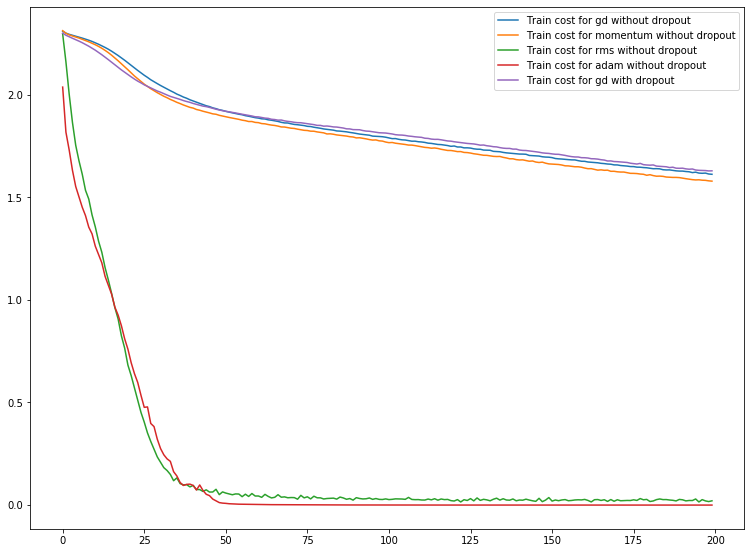

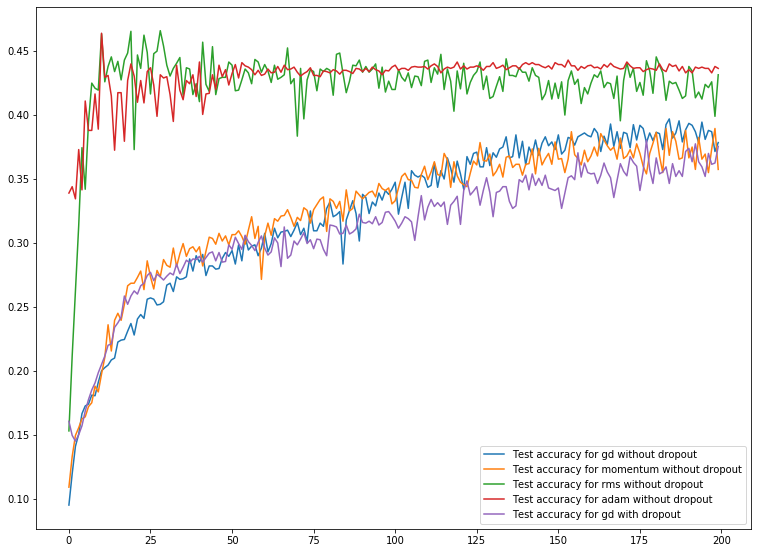

In [49]:
optimizer_list = [item['optimizer'] for item in comparisons]
dropout_list = [item['dropout'] for item in comparisons]

plot_optimizer_cost(f'partA_plots/q3_1.png', epochs, all_cost, optimizer_list, dropout_list)
plot_optimizer_acc(f'partA_plots/q3_2.png', epochs, all_acc, optimizer_list, dropout_list)